In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.signal import hilbert, savgol_filter, find_peaks
from scipy.interpolate import interp1d
from symreg import Promising_solution, Solution, Problem, create_arbitrary_constraint
import sympy as sp

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


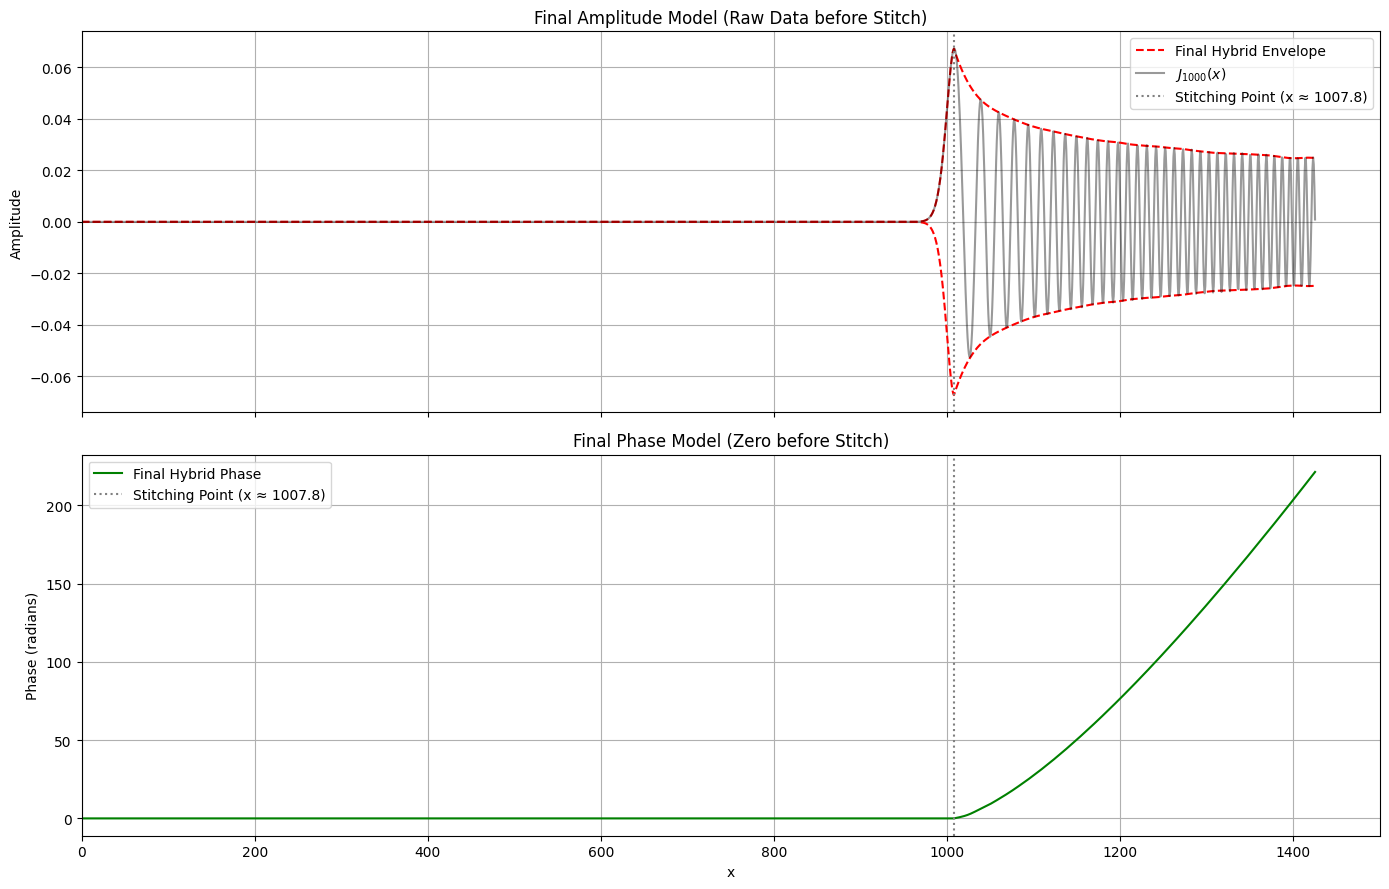

In [ ]:


# --- Step 1: Initial Setup and Finding Landmarks ---
order = 1000
x_full = np.linspace(0, 1500, 2000)
y_full = special.jv(order, x_full)

# Find peaks in the oscillatory region to define our stitching point
x_osc_region = x_full[x_full > 90]
y_osc_region = y_full[x_full > 90]
peaks_indices, _ = find_peaks(y_osc_region, distance=10)
x_peaks = x_osc_region[peaks_indices]
y_peaks = y_osc_region[peaks_indices]

# The stitching point is the first peak
x_stitch = x_peaks[0]


# --- Step 2: Create the "Right-Side" Models (for x >= x_stitch) ---
# This is our data-driven model for the main oscillatory region

# --- Amplitude Model (Smoothed Spline) ---
spline_func = interp1d(x_peaks, y_peaks, kind='cubic', bounds_error=False, fill_value=0)
x_right = x_full[x_full >= x_stitch]
amplitude_right = spline_func(x_right)
amplitude_right = savgol_filter(amplitude_right, 71, 3)
amplitude_right[amplitude_right < 0] = 0

# --- Phase Model (Hilbert Transform) ---
x_phase_calc_region = x_full[x_full >= 95]
y_phase_calc_region = y_full[x_full >= 95]
dt = x_phase_calc_region[1] - x_phase_calc_region[0]; pad_width = int(len(y_phase_calc_region) * 0.1); fit_points=50
y_padded_start = np.pad(y_phase_calc_region, (pad_width, 0), mode='symmetric')[:pad_width]
end_coeffs = np.polyfit(x_phase_calc_region[-fit_points:], y_phase_calc_region[-fit_points:], 1); end_poly = np.poly1d(end_coeffs)
x_end_pad = np.arange(1, pad_width + 1) * dt + x_phase_calc_region[-1]; y_end_pad = end_poly(x_end_pad)
y_padded = np.concatenate([y_padded_start, y_phase_calc_region, y_end_pad])
analytic_signal = hilbert(y_padded)[pad_width:-pad_width]
phase_calculated = np.unwrap(np.angle(analytic_signal))
phase_calculated = savgol_filter(phase_calculated, 41, 3)
phase_interp_func = interp1d(x_phase_calc_region, phase_calculated, kind='cubic', fill_value='extrapolate')
phase_right = phase_interp_func(x_right)
phase_right -= phase_right[0]


# --- NEW, SIMPLIFIED: Step 3: Create the "Left-Side" Models (for x < x_stitch) ---

# --- Amplitude Model: Use the raw Bessel function data ---
x_left = x_full[x_full < x_stitch]
# The "envelope" here is simply the absolute value of the true function
amplitude_left = np.abs(special.jv(order, x_left))

# --- Phase Model: Explicitly set to zero ---
phase_left = np.zeros_like(x_left)


# --- Step 4: Stitch and Trim the Final Model ---
amplitude_full = np.concatenate([amplitude_left, amplitude_right])
phase_full = np.concatenate([phase_left, phase_right])

# Apply final trim to the end of the arrays
final_trim_percent_end = 5.0 
trim_points = int(len(x_full) * final_trim_percent_end / 100)
x_final = x_full[:-trim_points]
y_final = y_full[:-trim_points]
amplitude_final = amplitude_full[:-trim_points]
phase_final = phase_full[:-trim_points]


# --- Step 5: Final Visualization ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True)

# Plot 1: Final Amplitude Envelope
ax1.plot(x_final, amplitude_final, label='Final Hybrid Envelope', color='red', linestyle='--')
ax1.plot(x_final, -amplitude_final, color='red', linestyle='--')
ax1.plot(x_final, y_final, color='k', alpha=0.4, label=f'$J_{{{order}}}(x)$')
ax1.axvline(x_stitch, color='gray', linestyle=':', label=f'Stitching Point (x ≈ {x_stitch:.1f})')
ax1.set_title('Final Amplitude Model (Raw Data before Stitch)')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True)

# Plot 2: Final Phase
ax2.plot(x_final, phase_final, label='Final Hybrid Phase', color='green')
ax2.axvline(x_stitch, color='gray', linestyle=':', label=f'Stitching Point (x ≈ {x_stitch:.1f})')
ax2.set_title('Final Phase Model (Zero before Stitch)')
ax2.set_ylabel('Phase (radians)')
ax2.set_xlabel('x')
ax2.legend()
ax2.grid(True)

plt.xlim(0, 1500)
plt.tight_layout()
plt.show()

In [77]:
amplitude_bessel_0_args = {
    'allowed_symbols': "add,sub,mul,div,constant,variable,sqrt",
    'epsilon': 1e-5,
    'objectives': ['rmse', 'length'], 
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*3,
    'n_threads': 12,
    'tournament_size': 3
}

amplitude_bessel_0 = Problem(f"Amplitude of Bessel (Hilbert decomp) of {order}", (x_final,  amplitude_final), (x_final,  amplitude_final), amplitude_bessel_0_args)

<Axes: title={'center': 'Amplitude of Bessel (Hilbert decomp) of 100 train'}, xlabel='X-axis', ylabel='Y-axis'>

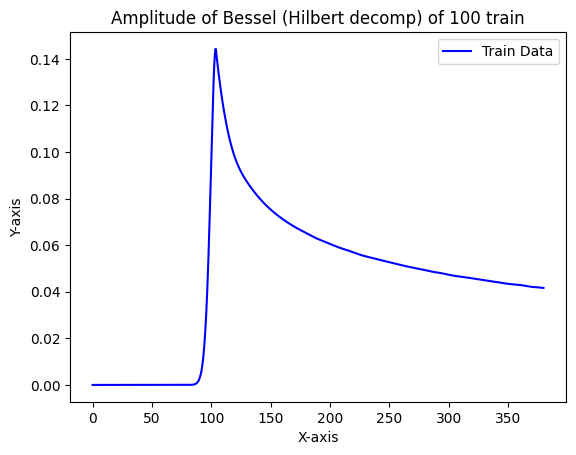

In [78]:
amplitude_bessel_0.plot_data()

In [79]:
amplitude_bessel_0.solve()

[0.03012598492205143, 5.0], 1754.90, (0.028371598572 + (0.000076035270 * (1.210339546204 * X1))), 0.00
[0.0287385992705822, 6.0], 1758.00, (0.007569621783 + (0.009184354916 * sqrt((0.102927684784 * X1)))), 0.00
[0.027955956757068634, 7.0], 1759.56, ((-0.027827952057) + (0.029314987361 * sqrt(sqrt((0.256692290306 * X1))))), 0.00
[0.023985082283616066, 8.0], 1765.32, ((-0.074176423252) + (0.018647782505 * (sqrt((1.121016502380 * X1)) + ((-0.038531169295) * X1)))), 0.00
[0.01849627122282982, 9.0], 1842.03, ((-16907.279296875000) + ((-16077.647460937500) * (((-1.051601529121) + (0.707106769085 * X1)) - (0.707106769085 * X1)))), 0.00
[0.018025411292910576, 11.0], 1858.59, ((-6198.815429687500) + ((-15787.718750000000) * (((-3.846496105194) + (0.707106769085 * X1)) - ((-3.453860759735) + (0.707106769085 * X1))))), 0.00
[0.017425714060664177, 12.0], 1775.23, ((-0.008911307901) + ((-0.000408765918) * ((0.911652088165 * X1) / ((sqrt((0.765192866325 * X1)) + ((-0.040421970189) * X1)) + (-5.24621

<Axes: title={'center': 'Amplitude of Bessel (Hilbert decomp) of 100 - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

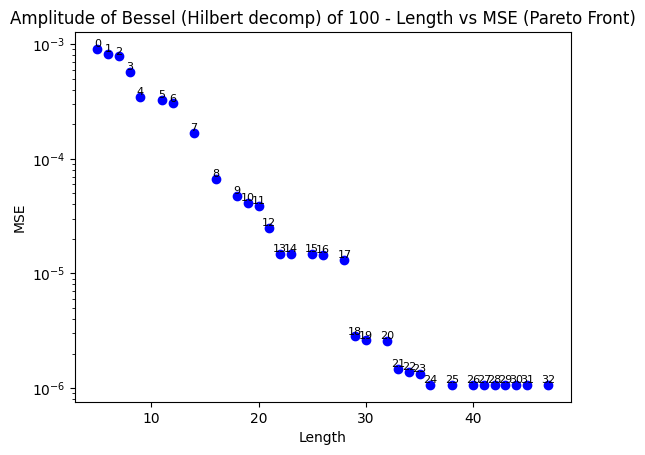

In [ ]:
amplitude_bessel_0.plot_l_vs_mse()

-X1**2*b0/(sqrt(X1)*b1 - X1*b2 - b3) - X1*b4*sqrt(X1*b5 + b6)/(-X1*b2 - b9 + sqrt(X1*b7 + b8)) + b10*sqrt(X1*b5 + b6)/(-X1*b2 - b9 + sqrt(X1*b7 + b8)) + b11


<IPython.core.display.Math object>

{'b0': 6.774911988550623e-07,
 'b1': 0.8944572184883555,
 'b2': 0.04063079878699938,
 'b3': 5.154925346375421,
 'b4': 1.1060741180896408e-05,
 'b5': 0.2851125299930004,
 'b6': 4.645235061646417,
 'b7': 0.7071067690850441,
 'b8': 4.196830749511719,
 'b9': 4.596756458281561,
 'b10': 0.0010476161081744984,
 'b11': 0.0035197616090001382}

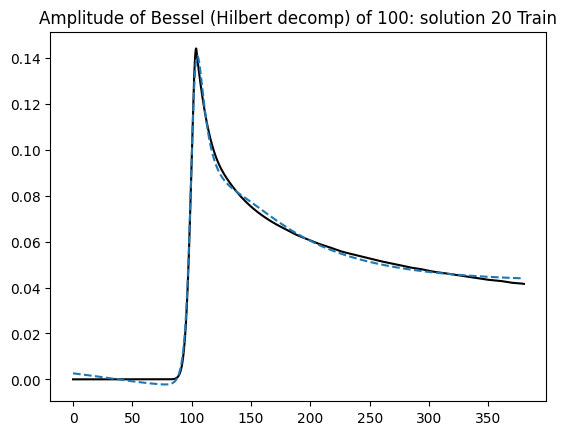

In [101]:
c_amp = 20
print(str(amplitude_bessel_0.solutions[c_amp].sympy_expr))
amplitude_bessel_0.solutions[c_amp].plot_results()
amplitude_bessel_0.solutions[c_amp].display_expression()
amplitude_bessel_0.solutions[c_amp].b_vals

In [84]:
candidate_str_ampl = 'sqrt(X1)*b5/(-X1*b1 - b4 + sqrt(X1*b2 + b3)) - 1/(-sqrt(X1)*b8 - b11 + sqrt(X1*b9 + b10))'
Candidate_ampl = Promising_solution(sp.parsing.sympy_parser.parse_expr(candidate_str_ampl), (x_final, amplitude_final), amplitude_bessel_0.solutions[c_amp], amplitude_bessel_0.solutions[c_amp].b_vals)

In [85]:
manual_expression_string = "b1*sqrt(b2)/(b5)"
manual_target_value =  np.sqrt(2/np.pi)
num_params = len(amplitude_bessel_0.solutions[c_amp].b_vals)
full_param_symbols = [sp.Symbol(f'b{i}') for i in range(num_params-1)]

parameter_limit_inf_constraint = create_arbitrary_constraint(manual_expression_string, manual_target_value, full_param_symbols ,constraint_type='eq')
constraints_man = []
constraints_man.append(parameter_limit_inf_constraint)

#Candidate_ampl.optimisation(constraints_eq=constraints_man)
Candidate_ampl.optimisation()

`xtol` termination condition is satisfied.
Number of iterations: 95, function evaluations: 940, CG iterations: 364, optimality: 6.71e+19, constraint violation: 0.00e+00, execution time: 0.14 s.

Optimization summary:
Parameter | Old Value   | New Value  | Abs Difference
--------- | ---------   | ---------  | --------------
b1        | 0.0406308   | 0.829263   | 0.788632      
b10       | 0.501278    | 0.116691   | 0.384586      
b11       | 5.15468     | 6.14699    | 0.992313      
b2        | 0.707107    | -0.0109966 | 0.718103      
b3        | 4.19683     | 4.17859    | 0.0182426     
b4        | 4.59676     | 4.82804    | 0.231287      
b5        | 0.000616764 | -1.13347   | 1.13408       
b8        | 0.040422    | -1.20611   | 1.24654       
b9        | 0.800054    | 1.52534    | 0.725289      



/home/danielct/Desktop/Internship_Oxford_2025/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


(-1.13346525533015*sqrt(X1)/(-0.829262898874624*X1 + sqrt(4.17858811572652 - 0.0109965606254437*X1) - 4.82804330099096) - 1/(1.206114197571*sqrt(X1) + sqrt(1.52534236835595*X1 + 0.116691145271569) - 6.14699270566416),
 {'b1': np.float64(0.8292628988746238),
  'b10': np.float64(0.11669114527156915),
  'b11': np.float64(6.146992705664162),
  'b2': np.float64(-0.010996560625443661),
  'b3': np.float64(4.178588115726522),
  'b4': np.float64(4.828043300990965),
  'b5': np.float64(-1.133465255330153),
  'b8': np.float64(-1.206114197570999),
  'b9': np.float64(1.5253423683559453)},
 {'b1': np.float64(0.7886321000876244),
  'b10': np.float64(0.3845864802894187),
  'b11': np.float64(0.9923134072632829),
  'b2': np.float64(0.7181033297104877),
  'b3': np.float64(0.018242633785196638),
  'b4': np.float64(0.23128684270940347),
  'b5': np.float64(1.1340820196085848),
  'b8': np.float64(1.2465361677600004),
  'b9': np.float64(0.72528865264996)},
 np.float64(28.807906705704433))

(-0.5, 0.5)

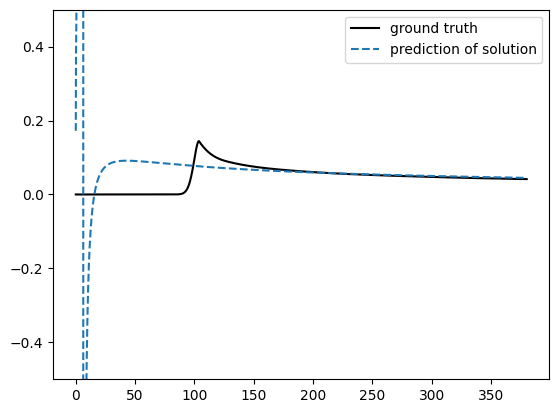

In [88]:
x_data = np.linspace(0, 200, 500)

#Candidate_ampl.plot_comparison(x_data, np.sqrt(2/(np.pi*x_data)))
Candidate_ampl.plot_comparison()
plt.ylim(-0.5, 0.5)

In [104]:
phase_bessel_0_args = {
    'allowed_symbols': "add,sub,mul,div,constant,variable",
    'epsilon': 1e-5,
    'objectives': ['rmse', 'length'], 
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*3,
    'n_threads': 12,
}

phase_bessel_0 = Problem(f"Phase of Bessel (Hilbert decomp) of {order}", (x_final, phase_final), (x_final, phase_final), phase_bessel_0_args)

In [105]:
phase_bessel_0.solve()

[39.628082275390625, 5.0], 1493635.25, ((-40.537284851074) + (0.670314848423 * (0.142293840647 * X1))), 1570.39
[30.91273307800293, 7.0], 909591.12, ((-24.475563049316) + ((-0.058354139328) * (((-0.458902060986) * X1) * (0.002862474648 * X1)))), 955.60
[20.89155387878418, 9.0], 416416.59, (34.645431518555 + (0.163586035371 * (((-1.353093862534) * X1) - (((-0.474671304226) * X1) * (0.002862474648 * X1))))), 436.46
[11.491960525512695, 11.0], 127249.33, (13.463989257812 + ((-0.000051290695) * ((((-2.750241041183) * X1) - (((-0.989769220352) * X1) * (0.002862474648 * X1))) * ((-1.443413615227) * X1)))), 132.07
[6.36873197555542, 13.0], 40325.21, (5.503001213074 + ((-0.000000153980) * ((((-0.474318504333) * X1) * (0.701959252357 * X1)) * (((-3.075129032135) * X1) - ((0.543891549110 * X1) * ((-0.005910869222) * X1)))))), 40.56
[4.8744916915893555, 15.0], 24370.13, ((-2.150203466415) + ((-0.000113060705) * (((((-0.458239942789) * X1) * (0.002862474648 * X1)) - ((-1.145745515823) * X1)) * (((

<Axes: title={'center': 'Phase of Bessel (Hilbert decomp) of 1000 - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

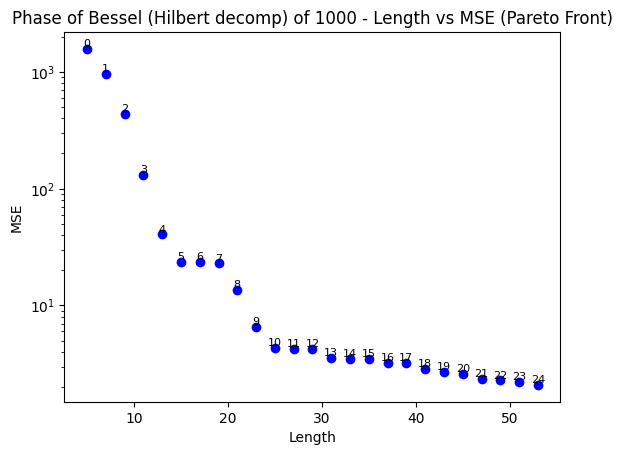

In [106]:
phase_bessel_0.plot_l_vs_mse()

X1*b0 - b1 - b2/(X1*b3 + X1*b4/(X1*b5 - b6) + X1*b7/(-X1*b9 + b8) - b10/(-X1*b9 + b11)) + b12/X1


<IPython.core.display.Math object>

{'b0': 0.9962954373449975,
 'b1': 155.41766357421875,
 'b2': 1494.8573384033516,
 'b3': 0.5880047082899864,
 'b4': 0.3640107214450268,
 'b5': 0.028915166855000507,
 'b6': 1.9387202262880692,
 'b7': 0.028893698006999813,
 'b8': 6.608863830566406,
 'b9': 0.013681041076999634,
 'b10': 0.35074627399399105,
 'b11': 6.139403343200684,
 'b12': 6937.782891511917}

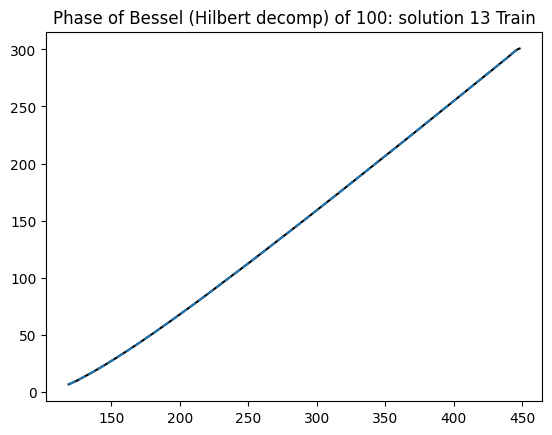

In [307]:
c_phi = 13
print(str(phase_bessel_0.solutions[c_phi].sympy_expr))
phase_bessel_0.solutions[c_phi].plot_results()
phase_bessel_0.solutions[c_phi].display_expression()
phase_bessel_0.solutions[c_phi].b_vals


In [457]:
candidate_str = f'X1 - ({order}*pi/2+pi/4) - b2/(X1*b3 + X1*b4/(X1*b5 - b6) + X1*b7/(-X1*b9 + b8) - b10/(-X1*b9 + b11)) + b12/X1'

Candidate_phase = Promising_solution(sp.parsing.sympy_parser.parse_expr(candidate_str), (x_data_spline_final, target_phase_spline_final), phase_bessel_0.solutions[c_phi], phase_bessel_0.solutions[c_phi].b_vals)

In [458]:
# manual_expression_string = "b2/b3 - b5"
# manual_target_value =  -(order*np.pi/2+np.pi/4)
# full_param_symbols = [sp.Symbol(f'b{i}') for i in range(1,8)]

# parameter_limit_inf_constraint = create_arbitrary_constraint(manual_expression_string, manual_target_value, full_param_symbols ,constraint_type='eq')
# constraints_man = []
# constraints_man.append(parameter_limit_inf_constraint)

Candidate_phase.optimisation()

`xtol` termination condition is satisfied.
Number of iterations: 3394, function evaluations: 40728, CG iterations: 36511, optimality: 1.17e+00, constraint violation: 0.00e+00, execution time:  7.2 s.

Optimization summary:
Parameter | Old Value | New Value | Abs Difference
--------- | --------- | --------- | --------------
b10       | 0.350746  | 0.52467   | 0.173924      
b11       | 6.1394    | 6.37593   | 0.236524      
b12       | 6937.78   | 6937.85   | 0.069423      
b2        | 1494.86   | 1494.82   | 0.0339062     
b3        | 0.588005  | 0.767303  | 0.179298      
b4        | 0.364011  | 0.975412  | 0.611401      
b5        | 0.0289152 | 0.0258641 | 0.00305106    
b6        | 1.93872   | 1.64446   | 0.29426       
b7        | 0.0288937 | 3.70085   | 3.67196       
b8        | 6.60886   | 5.22636   | 1.3825        
b9        | 0.013681  | 0.108297  | 0.0946158     



(X1 - 201*pi/4 - 1494.8234322216/(0.767302922630673*X1 + 0.975411671605931*X1/(0.0258641079926972*X1 - 1.64445989221715) + 3.70085130537577*X1/(5.22635946089293 - 0.108296864315334*X1) - 0.524670045978321/(6.37592771426275 - 0.108296864315334*X1)) + 6937.85231451215/X1,
 {'b10': np.float64(0.5246700459783213),
  'b11': np.float64(6.375927714262753),
  'b12': np.float64(6937.852314512154),
  'b2': np.float64(1494.823432221601),
  'b3': np.float64(0.7673029226306733),
  'b4': np.float64(0.9754116716059306),
  'b5': np.float64(0.02586410799269718),
  'b6': np.float64(1.6444598922171454),
  'b7': np.float64(3.7008513053757737),
  'b8': np.float64(5.226359460892935),
  'b9': np.float64(0.10829686431533445)},
 {'b10': np.float64(0.1739237719843303),
  'b11': np.float64(0.23652437106206925),
  'b12': np.float64(0.06942300023729331),
  'b2': np.float64(0.0339061817505808),
  'b3': np.float64(0.17929821434068693),
  'b4': np.float64(0.6114009501609038),
  'b5': np.float64(0.0030510588623033283)

X1 - b2/(X1*b3 + X1*b4/(X1*b5 - b6) + X1*b7/(-X1*b9 + b8) - b10/(-X1*b9 + b11)) - 201*pi/4 + b12/X1

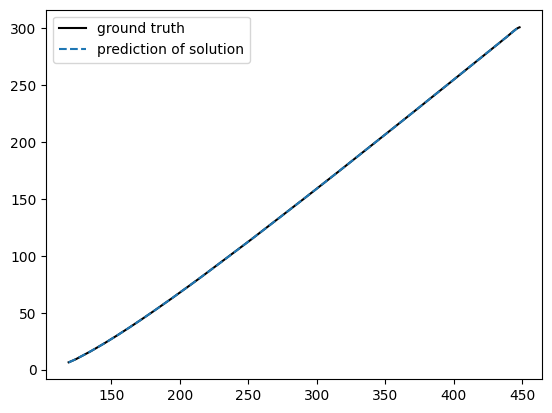

In [459]:
x_data = np.linspace(95, 100, 500)
#Candidate_phase.plot_comparison(x_data, y_data=x_data-order*np.pi/2-np.pi/4)
Candidate_phase.plot_comparison()
Candidate_phase.sympy_expr

Overall Mean Squared Error (MSE): 3.724730e-07


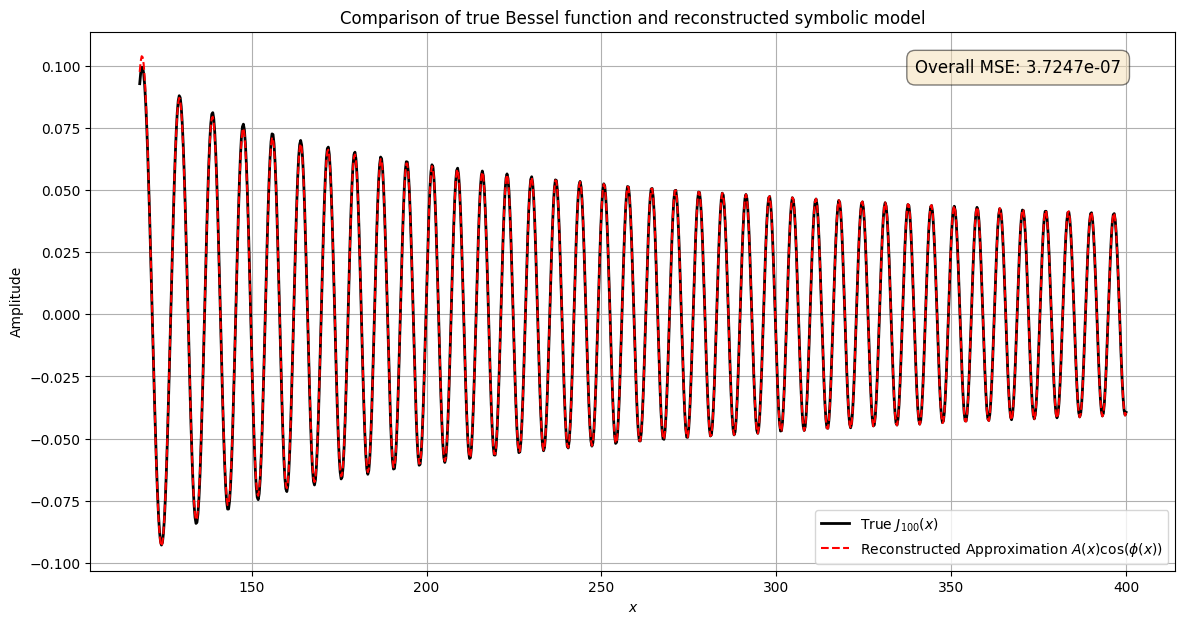

In [464]:

# 1. Define the symbolic variable
X1 = sp.Symbol('X1')

# 2. Extract the solution objects
# amp_solution = amplitude_bessel_0.solutions[4]
# phase_solution = phase_bessel_0.solutions[10]

amp_solution = Candidate_ampl
phase_solution = Candidate_phase


# 3. Get the symbolic expressions
A_expr = amp_solution.sympy_expr
phi_expr = phase_solution.sympy_expr

# --- STEP 1: SUBSTITUTE NUMERICAL CONSTANTS ---
# This is the critical new step.
# NOTE: You might need to change '.params' to the correct attribute name 
# that holds the dictionary of constant values (e.g., .constants_).
# A_numeric_expr = A_expr.subs(amp_solution.b_vals)
# phi_numeric_expr = phi_expr.subs(phase_solution.b_vals)

A_numeric_expr = A_expr.subs(amp_solution.modified_parameters)
phi_numeric_expr = phi_expr.subs(phase_solution.modified_parameters)

# 4. Combine the now-numeric expressions
bessel_approx_expr = A_numeric_expr * sp.cos(phi_numeric_expr)

# print("--- Final Expression with Numerical Constants ---")
# print(bessel_approx_expr)
# print("-" * 50)

# 5. Lambdify the final expression
# This now works because the only symbol left is X1.
# We keep the modules fix to be safe.
f_bessel_approx = sp.lambdify(
    (X1,), 
    bessel_approx_expr, 
    modules=[{'sqrt': np.sqrt}, 'numpy']
)

# 6. Generate data and plot (same as before)
x_data = np.linspace(118, 400, 1000)
y_true = special.jv(order, x_data)

# This call will now succeed.
y_pred = f_bessel_approx(x_data)


# Assuming y_true and y_pred have been calculated
overall_mse = calculate_mse(y_true, y_pred)

print(f"Overall Mean Squared Error (MSE): {overall_mse:.6e}")


# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(14, 7))

# Use the 'ax' object for all plotting commands
ax.plot(x_data, y_true, label=f'True $J_{{{order}}}(x)$', color='black', linewidth=2)
ax.plot(x_data, y_pred, label=r'Reconstructed Approximation $A(x) \cos(\phi(x)) $', color='red', linestyle='--')

# Set titles and labels on the axes object
ax.set_title('Comparison of true Bessel function and reconstructed symbolic model')
ax.set_xlabel('$x$')
ax.set_ylabel('Amplitude') # Added a Y-axis label for completeness
ax.legend()
ax.grid(True)

# The ax.text call will now work correctly
# (Assuming overall_mse is already calculated)
mse_text = f"Overall MSE: {overall_mse:.4e}"
ax.text(0.95, 0.95, mse_text, 
        transform=ax.transAxes, 
        fontsize=12,
        verticalalignment='top', 
        horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

# Use plt.show() to display the figure
plt.show()


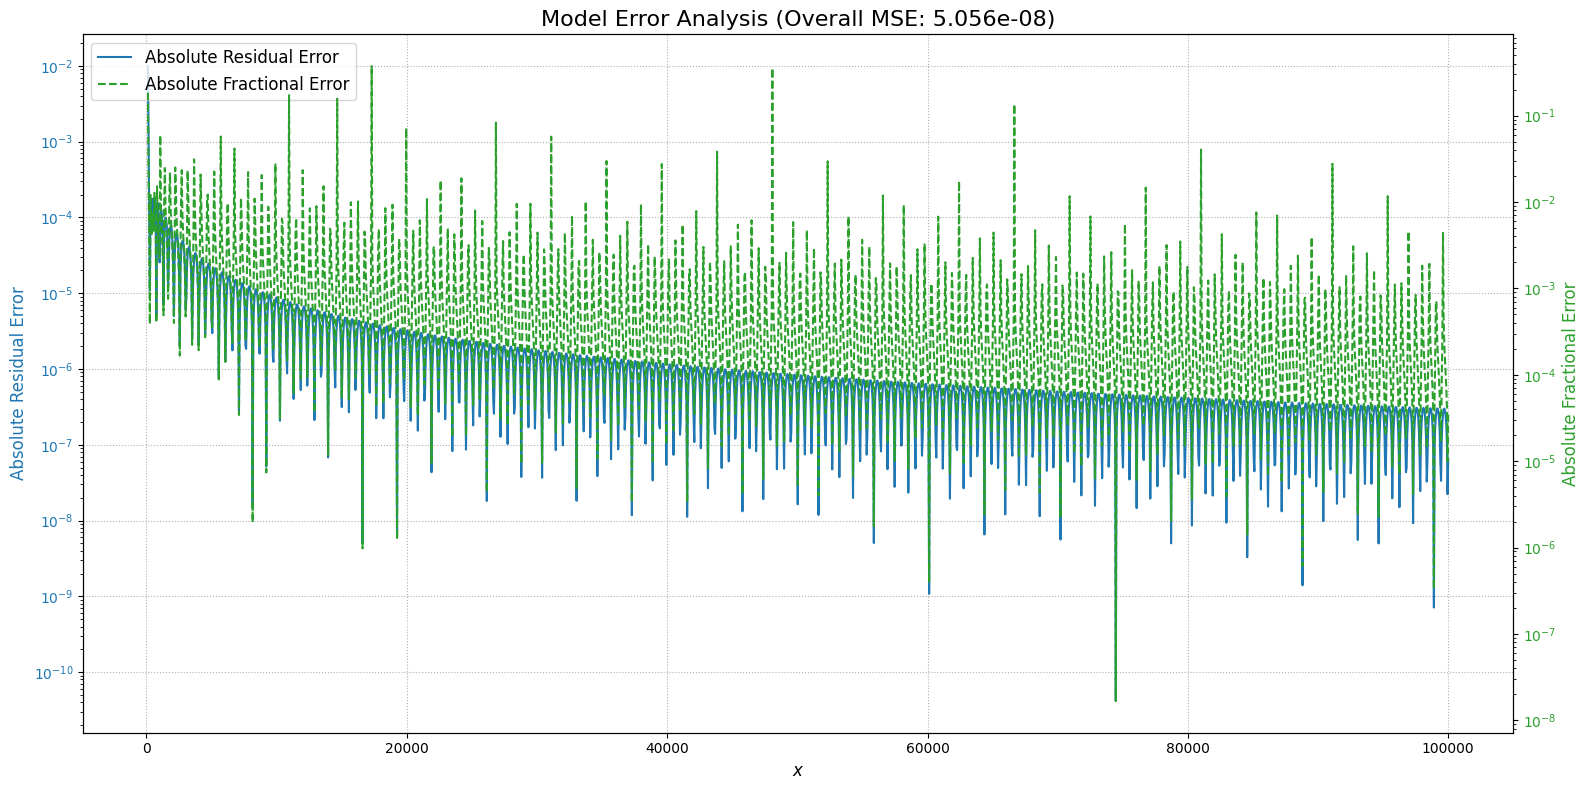

In [478]:
# Assume your calculate_mse function is defined elsewhere in your notebook
def calculate_mse(y_true, y_pred):
    return np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)

def plot_error_analysis(amp_candidate, phase_candidate, order_val, 
                        x_range=(110, 100000), num_points=2000,
                        plot_residual_abs=True, plot_fractional=True):
    """
    Generates a focused plot of the model's error, with options to show
    absolute residual error and/or fractional error.

    Args:
        amp_candidate: Your fitted candidate object for the amplitude.
        phase_candidate: Your fitted candidate object for the phase.
        order_val (int): The order of the Bessel function for the true data.
        x_range (tuple): The (start, end) of the x-axis for plotting.
        num_points (int): The number of points to generate for the plot.
        plot_residual_abs (bool): If True, plots the absolute residual error.
        plot_fractional (bool): If True, plots the absolute fractional error.
    """
    if not plot_residual_abs and not plot_fractional:
        print("No plots requested. Set 'plot_residual_abs' or 'plot_fractional' to True.")
        return

    X1 = sp.Symbol('X1')

    # 1. Prepare and lambdify the symbolic model
    A_expr = amp_candidate.sympy_expr.subs(amp_candidate.modified_parameters)
    phi_expr = phase_candidate.sympy_expr.subs(phase_candidate.modified_parameters)
    bessel_approx_expr = A_expr * sp.cos(phi_expr)
    f_bessel_approx = sp.lambdify((X1,), bessel_approx_expr, modules=['numpy'])

    # 2. Generate data
    x_data = np.linspace(x_range[0], x_range[1], num_points)
    y_true = special.jv(order_val, x_data)
    y_pred = f_bessel_approx(x_data)

    # 3. Calculate error metrics
    mse = calculate_mse(y_true, y_pred)
    residuals = y_true - y_pred
    absolute_residual_error = np.abs(residuals)
    
    epsilon = 1e-12 
    fractional_error = residuals / (np.abs(y_true) + epsilon)
    absolute_fractional_error = np.abs(fractional_error)

    # 4. Create the visualization based on flags
    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax1.set_title(f"Model Error Analysis (Overall MSE: {mse:.3e})", fontsize=16)
    ax1.set_xlabel('$x$', fontsize=12)
    ax1.grid(True, linestyle=':')

    # Case 1: Plot both using a twin axis
    if plot_residual_abs and plot_fractional:
        ax2 = ax1.twinx()
        line1 = ax1.plot(x_data, absolute_residual_error, color='#1f77b4', label='Absolute Residual Error')
        ax1.set_ylabel('Absolute Residual Error', color='#1f77b4', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='#1f77b4')
        ax1.set_yscale("log")

        line2 = ax2.plot(x_data, absolute_fractional_error, color='#2ca02c', linestyle='--', label='Absolute Fractional Error')
        ax2.set_ylabel('Absolute Fractional Error', color='#2ca02c', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='#2ca02c')
        ax2.set_yscale("log")
        
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=12)

    # Case 2: Plot only the absolute residual error
    elif plot_residual_abs:
        ax1.plot(x_data, absolute_residual_error, color='#1f77b4', label='Absolute Residual Error')
        ax1.set_ylabel('Absolute Residual Error', fontsize=12)
        ax1.set_yscale("log")
        ax1.legend(loc='upper left', fontsize=12)

    # Case 3: Plot only the fractional error
    elif plot_fractional:
        ax1.plot(x_data, absolute_fractional_error, color='#2ca02c', linestyle='--', label='Absolute Fractional Error')
        ax1.set_ylabel('Absolute Fractional Error', fontsize=12)
        ax1.set_yscale("log")
        ax1.legend(loc='upper left', fontsize=12)

    plt.tight_layout()
    plt.show()

# --- HOW TO USE THE FUNCTION ---
# This cell should be run AFTER your cell where 'Candidate_ampl', 
# 'Candidate_phase', and 'order' are defined.

# Example 1: Plot both (default behavior)
# plot_error_analysis(Candidate_ampl, Candidate_phase, order)

# Example 2: Plot only the absolute residual error
# plot_error_analysis(Candidate_ampl, Candidate_phase, order, plot_fractional=False)

# Example 3: Plot only the absolute fractional error
plot_error_analysis(Candidate_ampl, Candidate_phase, order, plot_residual_abs=True)